# Time Series Forecasting for Energy Consumption:

## Optimizing Resource Allocation in Smart Grid Systems

Name: Noel Stervin

DSML Student at Entri Elevate

Date: 13/05/2023

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import warnings
warnings.filterwarnings('ignore')

### Data Loading

In [2]:
df = pd.read_csv("I:\ENTRI\Final Project\energy_consumption_dataset.csv")

### Data Exploring

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43825 entries, 0 to 43824
Data columns (total 15 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Date/Time                           43825 non-null  object 
 1   Temperature                         43825 non-null  float64
 2   Humidity                            43825 non-null  float64
 3   Day of Week                         43825 non-null  object 
 4   Time of Day                         43825 non-null  object 
 5   Season                              43825 non-null  object 
 6   Holiday Indicator                   43825 non-null  int64  
 7   Previous Day's Energy Consumption   43825 non-null  float64
 8   Previous Week's Energy Consumption  43825 non-null  float64
 9   Energy Price                        43825 non-null  float64
 10  Daylight Hours                      43825 non-null  float64
 11  Wind Speed                          43825

In [4]:
df.columns

Index(['Date/Time', 'Temperature', 'Humidity', 'Day of Week', 'Time of Day',
       'Season', 'Holiday Indicator', 'Previous Day's Energy Consumption',
       'Previous Week's Energy Consumption', 'Energy Price', 'Daylight Hours',
       'Wind Speed', 'Solar Irradiance', 'Population Density',
       'Energy Consumption'],
      dtype='object')

In [5]:
print("First few rows of the DataFrame:")
print(df.head())

First few rows of the DataFrame:
             Date/Time  Temperature   Humidity Day of Week Time of Day  \
0  2020-01-01 00:00:00    17.440675  73.264794   Wednesday       00:00   
1  2020-01-01 01:00:00    25.759468  29.280938   Wednesday       01:00   
2  2020-01-01 02:00:00    20.138169  55.772252   Wednesday       02:00   
3  2020-01-01 03:00:00    17.244159  87.520015   Wednesday       03:00   
4  2020-01-01 04:00:00    11.182740  26.383045   Wednesday       04:00   

   Season  Holiday Indicator  Previous Day's Energy Consumption  \
0    Fall                  1                        4437.698981   
1  Spring                  1                        2240.248004   
2  Winter                  0                        1443.646518   
3  Summer                  0                        2325.184898   
4    Fall                  0                        1552.041035   

   Previous Week's Energy Consumption  Energy Price  Daylight Hours  \
0                         1799.303909      0.123

In [6]:
print("\nData types of columns:")
print(df.dtypes)


Data types of columns:
Date/Time                              object
Temperature                           float64
Humidity                              float64
Day of Week                            object
Time of Day                            object
Season                                 object
Holiday Indicator                       int64
Previous Day's Energy Consumption     float64
Previous Week's Energy Consumption    float64
Energy Price                          float64
Daylight Hours                        float64
Wind Speed                            float64
Solar Irradiance                      float64
Population Density                    float64
Energy Consumption                    float64
dtype: object


### Data Pre-processing

In [7]:
# Handling missing values
print("Missing values summary:")
print(df.isnull().sum())

Missing values summary:
Date/Time                             0
Temperature                           0
Humidity                              0
Day of Week                           0
Time of Day                           0
Season                                0
Holiday Indicator                     0
Previous Day's Energy Consumption     0
Previous Week's Energy Consumption    0
Energy Price                          0
Daylight Hours                        0
Wind Speed                            0
Solar Irradiance                      0
Population Density                    0
Energy Consumption                    0
dtype: int64


No missing or null values.

In [8]:
# Dealing with Duplicate Data
df[df.duplicated()]

,Date/Time,Temperature,Humidity,Day of Week,Time of Day,Season,Holiday Indicator,Previous Day's Energy Consumption,Previous Week's Energy Consumption,Energy Price,Daylight Hours,Wind Speed,Solar Irradiance,Population Density,Energy Consumption


In [9]:
# Outlier Detection and Treatment using Inter Quartile Range (IQR) Method

def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    initial_count = df.shape[0]
    df_cleaned = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    final_count = df_cleaned.shape[0]
    outliers_removed = initial_count - final_count
    return df_cleaned, outliers_removed

numerical_columns = df.select_dtypes(include=[np.number]).columns.tolist()
outliers_summary = {}

for col in numerical_columns:
    df, outliers_removed = detect_outliers(df, col)
    outliers_summary[col] = outliers_removed

print("Outliers Summary:")
for col, count in outliers_summary.items():
    print(f"{col}: {count} outliers detected & removed")

Outliers Summary:
Temperature: 0 outliers detected & removed
Humidity: 0 outliers detected & removed
Holiday Indicator: 2219 outliers detected & removed
Previous Day's Energy Consumption: 0 outliers detected & removed
Previous Week's Energy Consumption: 0 outliers detected & removed
Energy Price: 0 outliers detected & removed
Daylight Hours: 0 outliers detected & removed
Wind Speed: 0 outliers detected & removed
Solar Irradiance: 0 outliers detected & removed
Population Density: 0 outliers detected & removed
Energy Consumption: 0 outliers detected & removed


In [10]:
# Feature Scaling/Normalization
scaler = StandardScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

### Exploratory Data Analysis (EDA)

In [11]:
print("\nStatistical Summary:")
df.describe()


Statistical Summary:


,Temperature,Humidity,Holiday Indicator,Previous Day's Energy Consumption,Previous Week's Energy Consumption,Energy Price,Daylight Hours,Wind Speed,Solar Irradiance,Population Density,Energy Consumption
count,4.160600e+04,4.160600e+04,41606.0,4.160600e+04,4.160600e+04,4.160600e+04,4.160600e+04,4.160600e+04,4.160600e+04,4.160600e+04,4.160600e+04
mean,-5.913220e-17,1.978047e-16,0.0,-1.076761e-16,-1.237720e-16,-3.166881e-16,2.618895e-16,-2.403713e-16,7.753363e-17,6.651839e-17,6.745767e-18
std,1.000012e+00,1.000012e+00,0.0,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00
min,-1.718707e+00,-1.731676e+00,0.0,-1.744465e+00,-1.734019e+00,-1.724307e+00,-1.722497e+00,-1.719153e+00,-1.729471e+00,-1.733219e+00,-1.742490e+00
25%,-8.685917e-01,-8.711565e-01,0.0,-8.622221e-01,-8.716690e-01,-8.682177e-01,-8.707477e-01,-8.673128e-01,-8.664014e-01,-8.643945e-01,-8.638713e-01
50%,1.806114e-03,-1.573198e-03,0.0,8.007888e-03,5.775766e-03,1.810507e-03,-2.398989e-03,-7.848821e-03,2.609594e-03,-3.289236e-03,7.631020e-03
75%,8.674984e-01,8.654660e-01,0.0,8.667685e-01,8.675794e-01,8.633424e-01,8.665544e-01,8.628604e-01,8.628057e-01,8.670369e-01,8.679268e-01
max,1.733470e+00,1.730560e+00,0.0,1.737646e+00,1.720382e+00,1.746329e+00,1.737340e+00,1.734518e+00,1.739782e+00,1.736072e+00,1.724681e+00


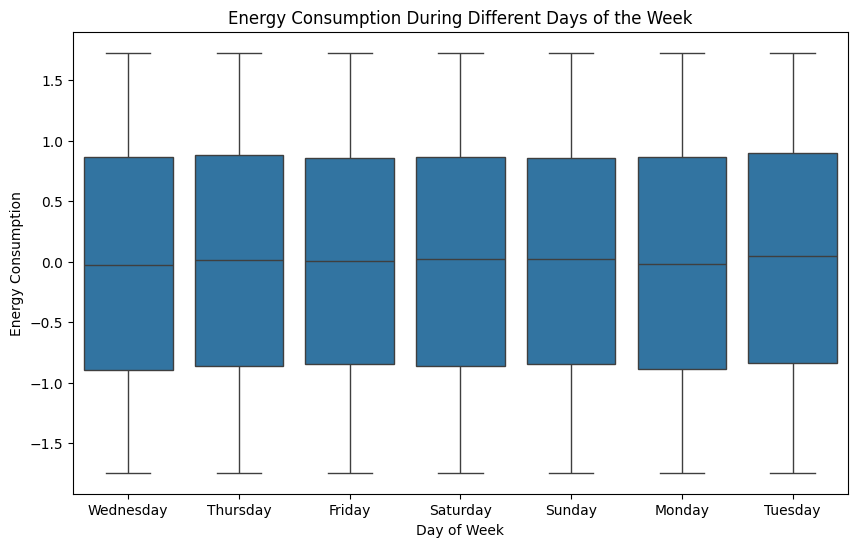

In [12]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Day of Week', y='Energy Consumption', data=df)
plt.title('Energy Consumption During Different Days of the Week')
plt.show()

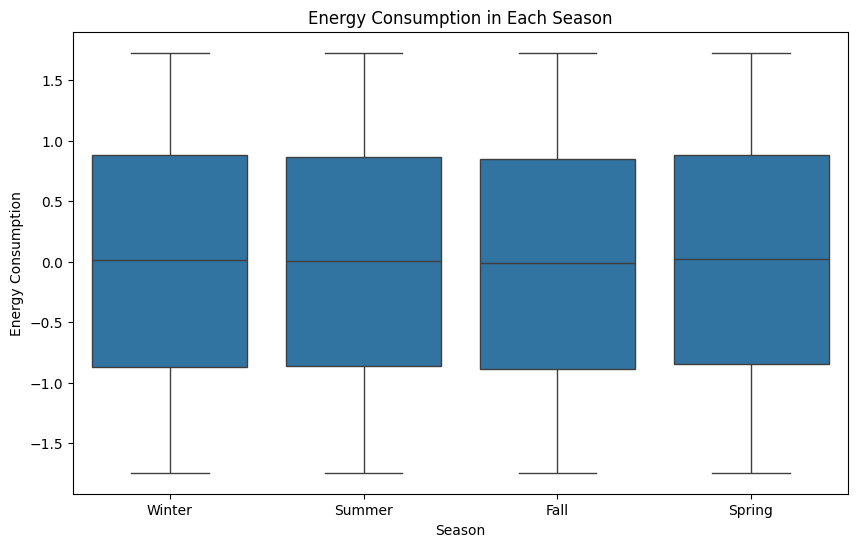

In [13]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Season', y='Energy Consumption', data=df)
plt.title('Energy Consumption in Each Season')
plt.show()

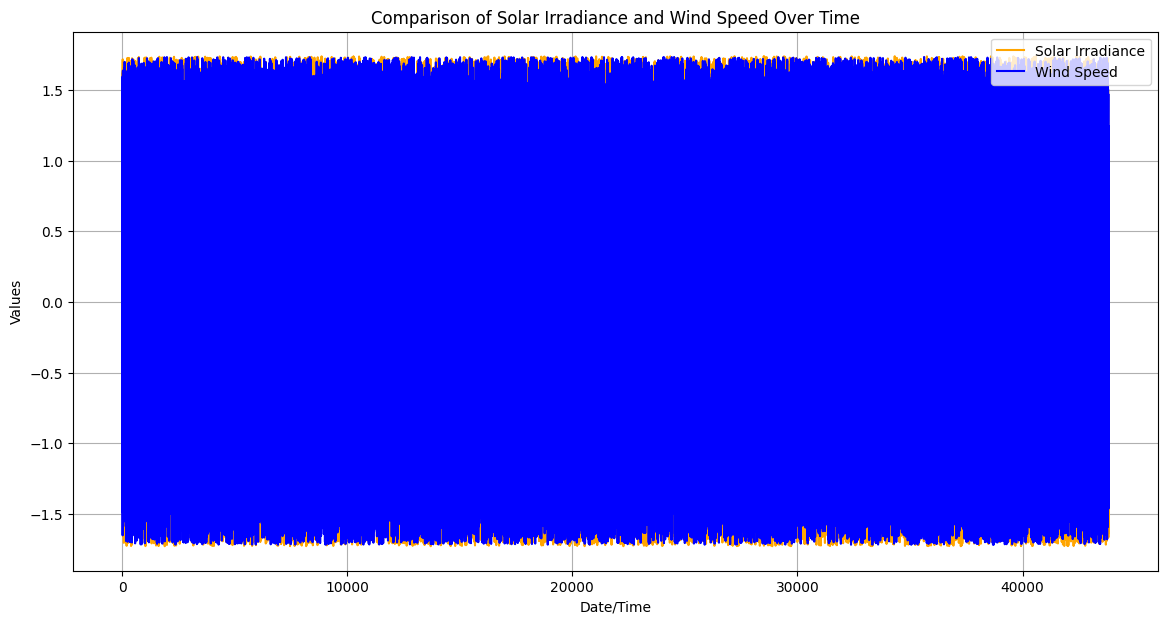

In [14]:
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Solar Irradiance'], label='Solar Irradiance', color='orange')
plt.plot(df.index, df['Wind Speed'], label='Wind Speed', color='blue')
plt.title('Comparison of Solar Irradiance and Wind Speed Over Time')
plt.xlabel('Date/Time')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

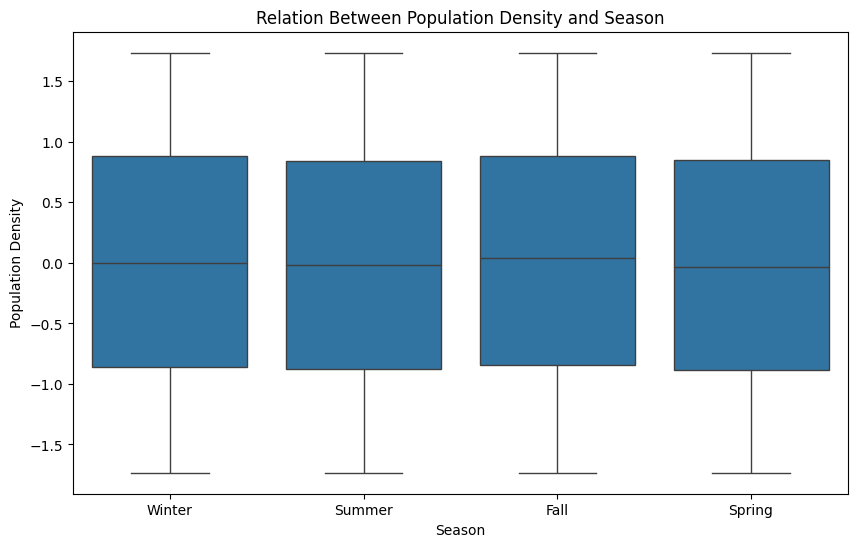

In [15]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Season', y='Population Density', data=df)
plt.title('Relation Between Population Density and Season')
plt.show()

### Feature Engineering

In [16]:
# Feature Engineering
df['Date/Time'] = pd.to_datetime(df['Date/Time'])
df['Day'] = df['Date/Time'].dt.day
df['Month'] = df['Date/Time'].dt.month
df['Year'] = df['Date/Time'].dt.year

label_encoder = LabelEncoder()
df['Season'] = label_encoder.fit_transform(df['Season'])
df['Day of Week'] = label_encoder.fit_transform(df['Day of Week'])
df['Time of Day'] = label_encoder.fit_transform(df['Time of Day'])
df['Holiday Indicator'] = label_encoder.fit_transform(df['Holiday Indicator'])

# Handling Repetitive Encoding
encoded_columns = ['Season', 'Day of Week', 'Time of Day', 'Holiday Indicator']
df = df.loc[:, ~df.columns.duplicated()]

# Feature Selection
X = df.drop(['Energy Consumption', 'Date/Time'], axis=1)
y = df['Energy Consumption']

select_k_best = SelectKBest(f_regression, k=10)
X_selected = select_k_best.fit_transform(X, y)

selected_features = X.columns[select_k_best.get_support()]

### Data Splitting

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)


### Model Selection and Training

In [18]:
# Using Exponential Smoothing for Time Series Forecasting
model_es = ExponentialSmoothing(y_train, seasonal='add', seasonal_periods=12).fit()

In [19]:
# Using ARIMA for Time Series Forecasting
model_arima = ARIMA(y_train, order=(5, 1, 0)).fit()

In [20]:
# Reshape the target variable for SARIMA model
y_train_series = pd.Series(y_train)
y_train_series.index = pd.date_range(start='1/1/2020', periods=len(y_train), freq='H') 

# Using SARIMA for Time Series Forecasting
model_sarima = SARIMAX(y_train_series, order=(1, 1, 1), seasonal_order=(1, 1, 1, 24)).fit()

In [21]:
# Support Vector Regression (SVR)
param_grid_svr = {'C': [1, 10, 100], 'epsilon': [0.1, 0.2, 0.5]}
grid_search_svr = GridSearchCV(SVR(kernel='rbf'), param_grid_svr, cv=3)
grid_search_svr.fit(X_train, y_train)
model_svr = grid_search_svr.best_estimator_

In [22]:
# Random Forest Regressor
param_grid_rf = {'n_estimators': [100, 200], 'max_depth': [10, 20]}
grid_search_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=3)
grid_search_rf.fit(X_train, y_train)
model_rf = grid_search_rf.best_estimator_

In [23]:
# Gradient Boosting Regressor
param_grid_gb = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1]}
grid_search_gb = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid_gb, cv=3)
grid_search_gb.fit(X_train, y_train)
model_gb = grid_search_gb.best_estimator_

### Model Evaluation

In [24]:
# Predictions using Exponential Smoothing
y_pred_es = model_es.forecast(len(y_test))

# Predictions using ARIMA
y_pred_arima = model_arima.forecast(steps=len(y_test))

# Predictions using SARIMA
y_pred_sarima = model_sarima.forecast(steps=len(y_test))

# Predictions using SVR
y_pred_svr = model_svr.predict(X_test)

# Predictions using Random Forest
y_pred_rf = model_rf.predict(X_test)

# Predictions using Gradient Boosting
y_pred_gb = model_gb.predict(X_test)

In [25]:
# Evaluation Metrics
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2

In [26]:
# Evaluate Exponential Smoothing Model
mae_es, mse_es, rmse_es, r2_es = evaluate_model(y_test, y_pred_es)
print(f"Exponential Smoothing - MAE: {mae_es}, MSE: {mse_es}, RMSE: {rmse_es}, R^2: {r2_es}")

Exponential Smoothing - MAE: 0.8779769778806199, MSE: 1.0196380719392284, RMSE: 1.0097712968485628, R^2: -0.00163069802689364


In [27]:
# Evaluate ARIMA Model
mae_arima, mse_arima, rmse_arima, r2_arima = evaluate_model(y_test, y_pred_arima)
print(f"ARIMA - MAE: {mae_arima}, MSE: {mse_arima}, RMSE: {rmse_arima}, R^2: {r2_arima}")

ARIMA - MAE: 0.9222571025184604, MSE: 1.1708017445818215, RMSE: 1.0820359257352878, R^2: -0.1501247363647773


In [28]:
# Evaluate SARIMA Model
mae_sarima, mse_sarima, rmse_sarima, r2_sarima = evaluate_model(y_test, y_pred_sarima)
print(f"SARIMA - MAE: {mae_sarima}, MSE: {mse_sarima}, RMSE: {rmse_sarima}, R^2: {r2_sarima}")

SARIMA - MAE: 0.8780736166173368, MSE: 1.0199925610807699, RMSE: 1.009946811015694, R^2: -0.00197892669357147


In [29]:
# Evaluate SVR Model
mae_svr, mse_svr, rmse_svr, r2_svr = evaluate_model(y_test, y_pred_svr)
print(f"SVR - MAE: {mae_svr}, MSE: {mse_svr}, RMSE: {rmse_svr}, R^2: {r2_svr}")

SVR - MAE: 0.8778801612974406, MSE: 1.0191972773117906, RMSE: 1.0095530086685842, R^2: -0.001197688077071657


In [30]:
# Evaluate Random Forest Model
mae_rf, mse_rf, rmse_rf, r2_rf = evaluate_model(y_test, y_pred_rf)
print(f"Random Forest - MAE: {mae_rf}, MSE: {mse_rf}, RMSE: {rmse_rf}, R^2: {r2_rf}")

Random Forest - MAE: 0.8799186044320156, MSE: 1.0238895958195862, RMSE: 1.0118742984282119, R^2: -0.00580713763733498


In [31]:
# Evaluate Gradient Boosting Model
mae_gb, mse_gb, rmse_gb, r2_gb = evaluate_model(y_test, y_pred_gb)
print(f"Gradient Boosting - MAE: {mae_gb}, MSE: {mse_gb}, RMSE: {rmse_gb}, R^2: {r2_gb}")

Gradient Boosting - MAE: 0.8781799887339523, MSE: 1.0196630523690613, RMSE: 1.0097836661231263, R^2: -0.0016552372884799382


In [32]:
# Model Deployment
models = {
    'Exponential Smoothing': (model_es, r2_es),
    'ARIMA': (model_arima, r2_arima),
    'SARIMA': (model_sarima, r2_sarima),
    'SVR': (model_svr, r2_svr),
    'Random Forest': (model_rf, r2_rf),
    'Gradient Boosting': (model_gb, r2_gb)
}

best_model_name = max(models, key=lambda k: models[k][1])
best_model = models[best_model_name][0]

print(f"Best Model: {best_model_name}")

Best Model: SVR


### Inferences

Tuesday shows higher energy consumption as compared to other days of the week.

There is a small dip in energy consumption in fall. This can be due to the fact the climate at that time is generally not too hot or too cold.

There is a dip in population density in summer and spring, suggesting people could be travelling to other countries for vacations.
                                                                                                                   
Solar Irradiance and Wind Speed Over Time are favourable and can help adopting sustainable and renewable energy sources in nature.    

Best model is SVR.


### Conclusion

This project explores various time series forecasting models for predicting energy consumption. Techniques implemented are data splitting, model training, hyperparameter optimization using GridSearchCV, and evaluation using metrics like MAE, MSE, RMSE, and R^2. They can help discover valuable insights in this dataset. By analyzing evaluation metrics, we can select the most suitable model for forecasting future energy consumption based on our specific requirements.
Future investigation could involve incorporating additional features or exploring advanced forecasting techniques.

References
DSML Course from Entri Elevate
ChatGPT
Google